# Comparing our Welfare idea to individual fairness notions

### In this notebook we look at how individual notions of fairness (Dwork et al 2012, Speicher et al 2018) behave when we maximizing social welfare

Import necessary dependencies.
Note that the modules "load_compas_data_modified", "utils" and "funcs_disp_mist_modified" are adopted from "Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment" by Zafar et. al.

In [2]:
import numpy as np
import pandas as pd
from load_compas_data_modified  import *
import funcs_disp_mist_modified as fdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import utils_modified as ut
from cvxpy import *
import ncvx
from scsprox import Prox

### Defining a utility function

In [196]:
# this complies with the cvxpy framework that we use to optimize
# but it doesn't give back a number
def avg_utility(y_pred, y_actual,alpha):
    #assert(y_pred.shape[0] == y.shape[0])
    n = y_actual.shape[0]
    s = sum_entries(power(((y_pred-y_actual)+10),alpha))
    return s/n 

# this is essentially the same function but it can't be used with the cvxpy framework
# we use this one when we need to produce a number as an output
def eval_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = sum(np.power((np.subtract(y_pred,y_actual)+10),alpha))
    return s/n 

### Defining functions to compute violations w.r.t. individual Fairness constraints

For the generalized entropy measure of Speicher et al a constant (they call is alpha) is needed, we use 2 and therefore call the measure GE2

In [197]:
# x1 and x2 are feature vectors, we use euclidian distance
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def avg_Dwork_violation(y_pred, X_data):
    # go trough all pairs of predictions and see if constraints are violated
    violation_sum = 0
    n = y_pred.shape[0]
    assert(X_data.shape[0] == n)
    for i in range(n):
        for j in range(i+1,n):
            violation_sum += np.maximum(0, np.absolute(y_pred[i] - y_pred[j]) - distance(X_data[i,:],X_data[j,:]))
    return 2*violation_sum/(n*(n-1))
    
# y_pred and y_actual are vectors of predictions
# return value is a scalar
def ge2(y_pred, y_actual):
    n = y.shape[0]
    benefit = (np.subtract(y_pred,y_actual)+1)
    mu = np.average(benefit)
    return 0.5*np.average(np.power(benefit/mu,2)) - 0.5

precomputing the distance matrices to save time, not used in implementation right now

In [73]:
n = x_train.shape[0]
D_train = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        D_train[i,j] = distance(x_train[i,:], x_train[j,:])

In [67]:
########### sanity check
D = np.matrix(([0,5,10],[5,0,19],[10,19,0]))
pred = np.array((90,80,-50))
print(avg_Dwork_violation(pred,D))

74.2563168401449


## Importing the COMPAS dataset

Here we import the COMPAS dataset. It is preprocessed the same way as in the ProPublica study (refer to https://github.com/propublica/compas-analysis)

In [3]:
#data_type = 1
X, y, x_control = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 

(5278, 8)


## Train the utility model

In [199]:
"""permute the data randomly"""
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
#for k in list(x_control.keys()):
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)



In [202]:
sensitive_attrs = list(x_control.keys())


# set the alpha parameter for our utility function
alpha = 1

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6 # tolerance parameter for the optimizer
loss_function = "logreg" # perform the experiments with logistic regression

num_points, num_features = x_train.shape

# initialize a random value of the weight vectors
w_uncons = Variable(num_features)
w_uncons.value = np.random.rand(x_train.shape[1])
w_cons = Variable(num_features)
w_cons.value = np.random.rand(x_train.shape[1])


# train an unconstrained classifier for reference
w_uncons = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)


train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_uncons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

util_uncons = eval_util((np.dot(x_train, w_uncons)), y_train,alpha)
print("Utility without constraints: " + str(util_uncons) + "\n")

        
# threshold that average utility needs to be above, called epsilon in the plots  
threshold = 15
y_pred = (x_train*w_cons)

# logistic loss
loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent


util = avg_utility(y_pred, y_train, alpha)

# utility for both groups needs to be above threshold
# w constrained to not allow arbitrary utlity increase by scaling
constraints = [threshold <= util, w_cons <= 10]

prob = Problem(Minimize(loss), constraints)

tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset


try:
    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=ECOS, verbose=False,
            max_iters=max_iters, max_iter=max_iter_dccp)
except Exception as e:
    print (e)

#convert solution vector to a numpy array
w_cons = np.array(w_cons.value).flatten()
print(prob.status)
print(prob.is_dcp())
print(w_cons)
# achieved utilities of constrained classifier
util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

dwork_vio = avg_Dwork_violation(np.sign(np.dot(x_train, w_cons)), x_train)
genent2 = ge2(np.sign(np.dot(x_test, w_cons)), y_test)


train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

print("Utility with constraints: " + str(util_cons) + "\n")
print("Avg violation of Dwork et al constraints: " + str(dwork_vio) + "\n")
print("generalized entropy: " + str(genent2) + "\n")

[ 1. -1.  1. ... -1. -1.  1.]


Accuracy: 0.664
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.28 ||
||  1  || 0.17 || 0.62 ||


Utility without constraints: 9.951872976097839

Converged
True
[-0.13936691  4.76271972  3.60229208  6.29637781 -0.18782154  0.47050215
  7.37300145 -0.0865743 ]
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.586
||  s  || FPR. || FNR. ||
||  0  || 0.77 || 0.09 ||
||  1  || 0.53 || 0.21 ||


Utility with constraints: 14.999999999999654

Avg violation of Dwork et al constraints: 0.10442493483900529

generalized entropy: 0.26416750373021536



## Behavior of individual fairness when varying parameters of social welfare

### Individual fairness vs Epsilon

Notes: 
    - utility for unconstrained is around 9.90 for group 1 and 9.96 for group 0 (for alpha = 1)
    - at a threshold of 40, all samples were classified as positive
    - for alpha=1 the scanned region of thresholds was therefore 9-40
    - for alpha=0.5 it was 3-6 for the same reasons
    - w element-wise constrained to be smaller equal 10

In [205]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 20
cross_val_iter = 4

# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0
# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(3,6,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)
dwork_array = np.zeros(threshold_iter)
ge_array = np.zeros(threshold_iter)

for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    dwork = 0
    ge = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        
        y_pred_test = np.sign(np.dot(x_test, w_cons))
        y_pred_train = np.sign(np.dot(x_train, w_cons))
        
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        dwork += avg_Dwork_violation(y_pred_train, x_train)
        ge += ge2(y_pred_train, y_train)
        print("Utility with constraints: " + str(util_cons) + "\n")
    accuracy = accuracy / cross_val_iter
    l = l / cross_val_iter
    accuracy_array[j] = accuracy
    loss_array[j] = l
    dwork_array [j] = dwork / cross_val_iter
    ge_array[j] = ge / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[-1. -1. -1. ...  1.  1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.30 ||
||  1  || 0.15 || 0.63 ||


Utility with constraints: 3.149283430345103

#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ... -1. -1. -1.]


Accuracy: 0.666
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.32 ||
||  1  || 0.17 || 0.61 ||


Utility with constraints: 3.152125666023666

#############cross validation iteration 2 #########################
None
[-1.  1.  1. ... -1. -1.  1.]


Accuracy: 0.657
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.32 ||
||  1  || 0.17 || 0.61 ||


Utility with constraints: 3.1490276460351527

#############cross validation iteration 3 #########################
None
[-1. -1. -1. ...  1.  1. -1.]


Accuracy: 0.676
||  s  || FPR. || FNR. ||
||  0  || 0.41 || 0.26 ||
||  1  || 0.16 || 0.5

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.502
||  s  || FPR. || FNR. ||
||  0  || 0.97 || 0.02 ||
||  1  || 0.85 || 0.07 ||


Utility with constraints: 4.105263158233712

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.521
||  s  || FPR. || FNR. ||
||  0  || 0.93 || 0.02 ||
||  1  || 0.83 || 0.05 ||


Utility with constraints: 4.105263158070974

#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...  1. -1.  1.]


Accuracy: 0.524
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.83 || 0.03 ||


Utility with constraints: 4.105263158072785

########Test accuracy: 0.5127921667719519 (for threshold iteration) 7 ############

#############Threshold value iteration 8 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.521
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.83 || 0.04 ||


U

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.96 || 0.01 ||


Utility with constraints: 5.2105263191316

########Test accuracy: 0.4812065698041693 (for threshold iteration) 14 ############

#############Threshold value iteration 15 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.488
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.94 || 0.04 ||


Utility with constraints: 5.368421054957708

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.467
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.98 || 0.00 ||


Utility with constraints: 5.3684210579293845

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.474
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.02 ||


Utilit

### Individual fairness vs Alpha

- We set epsilon to 5 and vary alpha between 0.45 and 1, for lower alpha values the solver fails
- When epsilon = 2 we can go as low as alpha = 0.2
- Note that when alpha < 0 then the problem is not a dcp problem anymore and the solver won't be able to find a solution

In [209]:
sensitive_attrs = list(x_control.keys())

# how many equispaced alpha values to try within the range specified later 
alpha_iter = 10
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0
# specify range for alpha parameters to try
alpha_array = np.linspace(0.45,1,alpha_iter)

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 5
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(alpha_iter)
loss_array = np.zeros(alpha_iter)
dwork_array = np.zeros(alpha_iter)
ge_array = np.zeros(alpha_iter)

for j in range(0,alpha_iter):
    print("#############Alpha value iteration " + str(j) + " #########################")
    alpha = alpha_array[j]
    
    accuracy = 0
    l = 0
    dwork = 0
    ge = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        
        y_pred_test = np.sign(np.dot(x_test, w_cons))
        y_pred_train = np.sign(np.dot(x_train, w_cons))
        
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        dwork += avg_Dwork_violation(y_pred_train, x_train)
        ge += ge2(y_pred_train, y_train)
        print("Utility with constraints: " + str(util_cons) + "\n")
    accuracy = accuracy / cross_val_iter
    l = l / cross_val_iter
    accuracy_array[j] = accuracy
    loss_array[j] = l
    dwork_array [j] = dwork / cross_val_iter
    ge_array[j] = ge / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Alpha value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.478
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 5.000000011469162

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.454
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 5.000000017448452

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.469
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 5.000000019073378

#############cross validation iteration 3 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.472
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constrain

[-1.  1. -1. ...  1. -1.  1.]


Accuracy: 0.666
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.30 ||
||  1  || 0.16 || 0.62 ||


Utility with constraints: 6.5365275675547965

#############cross validation iteration 1 #########################
None
[-1. -1. -1. ...  1. -1. -1.]


Accuracy: 0.678
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.29 ||
||  1  || 0.17 || 0.59 ||


Utility with constraints: 6.511515883731495

#############cross validation iteration 2 #########################
None
[ 1. -1. -1. ... -1.  1. -1.]


Accuracy: 0.647
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.35 ||
||  1  || 0.16 || 0.62 ||


Utility with constraints: 6.520420455518036

#############cross validation iteration 3 #########################
None
[-1. -1. -1. ... -1. -1. -1.]


Accuracy: 0.686
||  s  || FPR. || FNR. ||
||  0  || 0.34 || 0.31 ||
||  1  || 0.14 || 0.57 ||


Utility with constraints: 6.530370212985056

#############cross validation iteration 4 #########################
None
[-1. -1.  1. ..

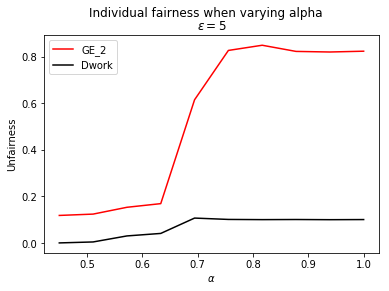

In [211]:
plt.plot(alpha_array, dwork_array,'k', alpha_array, ge_array, 'r')
plt.suptitle('Individual fairness when varying alpha')
plt.title('$\epsilon = 5$')
plt.ylabel('Unfairness')
plt.xlabel('$\\alpha$')
red_line = mlines.Line2D([], [], color='red',
                          markersize=15, label='GE_2')
black_line = mlines.Line2D([], [], color='black',
                          markersize=15, label='Dwork')
plt.legend(handles=[red_line,black_line])
plt.show()

In [117]:
saved_dwork = dwork_array
saved_ge = ge_array

In [178]:
print(np.power(3.0,-1))

0.3333333333333333
